In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import random
from datetime import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.behaviors.events import EventManager
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.utils import to_nd
from tyssue.io import hdf5


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import VitellineElasticity
from invagination.delamination import (define_mesoderm,
                                       check_enter_in_process,
                                       check_tri_faces,
                                       type1_transition)
from invagination.contractility_gradient import constriction

from invagination.plots import mesoderm_position


import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/SimulationsReview')


In [2]:
import datetime

today = datetime.date.today()

#sim_save_dir = SIM_DIR/f'{today.isoformat()}_TEST1'
sim_save_dir = SIM_DIR/f'2018-09-10_TEST0'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [3]:
#%pdb

In [4]:
class RadialTension(effectors.AbstractEffector):
    
    dimensions = units.line_tension
    magnitude = 'radial_tension'
    label = 'Apical basal tension'
    element = 'vert'
    specs = {'vert':{'is_active',
             'height',
             'radial_tension'}}

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            'height * radial_tension * is_active')
         
    @staticmethod
    def gradient(eptm):
        grad = height_grad(eptm) * to_nd(
            eptm.vert_df.eval('radial_tension'), 3)
        grad.columns = ['g'+c for c in eptm.coords]
        return grad, None
    
    
EllipsoidSModel = model_factory(
    [
    RadialTension,
    VitellineElasticity,
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceVolumeElasticity,
    ], effectors.FaceAreaElasticity)


EllipsoidBModel = model_factory(
    [
    RadialTension,
    VitellineElasticity,
    #effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceAreaElasticity,
    effectors.CellVolumeElasticity,
    ], effectors.FaceAreaElasticity)


model = EllipsoidBModel


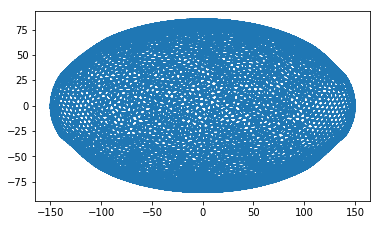

In [5]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet_init.hf5',
                           data_names=['vert', 'edge', 'face', 'cell'])


with open('../data/json/ellipsoid.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('ellipse', dsets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.settings['vitelline_space'] = 0.2
sheet.vert_df['radial_tension'] = 0.
sheet.cell_df['prefered_vol'] = 4539601.384437251
sheet.cell_df['vol_elasticity'] = 3.e-6

fig, ax = quick_edge_draw(sheet, coords=list('zx'))

In [6]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                          'options': {'ftol': 1e-8,
                                      'gtol': 1e-8}}}

## Define cells in the mesoderm

number of apoptotic cells: 849


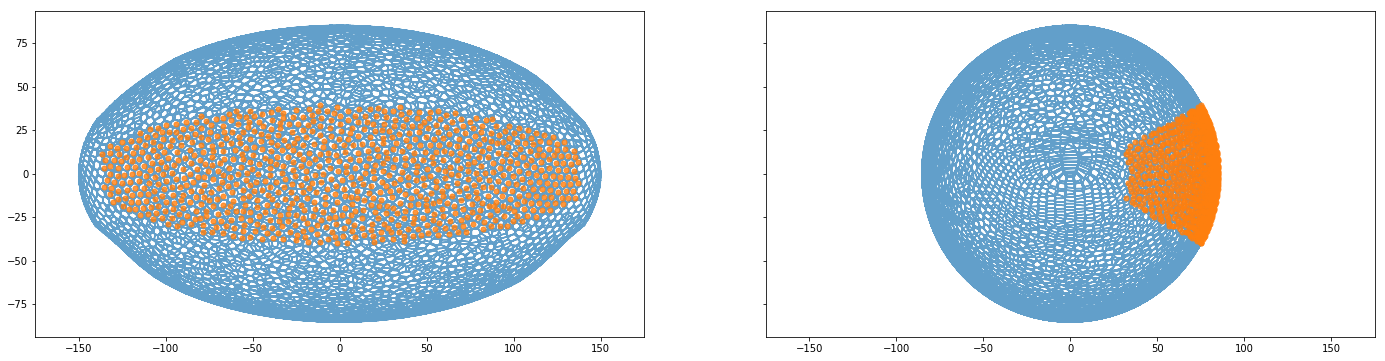

In [7]:
# Define rectangular mesoderm
#define_cell_in_mesoderm(sheet, 0.3, 0.7 ,0.05, 0.95)

# Define ovoid mesoderm
define_mesoderm(sheet, 145, 40)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
delaminating_cells = sheet.face_df[sheet.face_df['is_mesoderm']].index



print('number of apoptotic cells: {}'.format(delaminating_cells.size))
mesoderm_position(sheet, delaminating_cells)

number of apoptotic cells: 849


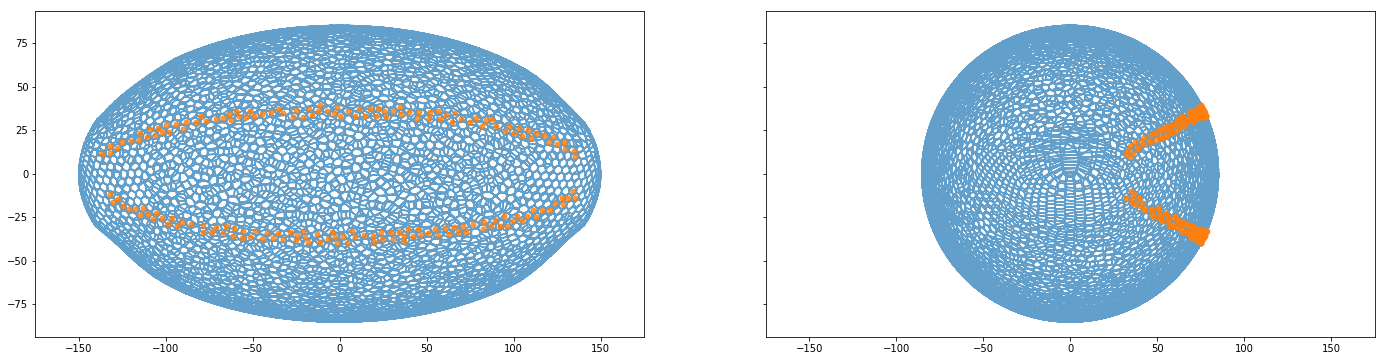

In [8]:
# define the last 2 lines cells 

def define_relaxation_cells(sheet, a=145., b=40.,
                            aa=145., bb=40.,
                    coords=['x', 'z', 'y']):
    """
    Define an oval area that will become the mesoderm.

    a: radius on the first-axis
    b: radius on the second-axis
    """
    define_mesoderm(sheet, aa, bb)
    x, y, z = coords
    x_ = sheet.face_df[x] / b
    y_ = sheet.face_df[y] / a

    rayon = x_**2 + y_**2
    height = sheet.face_df[z]

    sheet.face_df['is_relaxation'] = ~((rayon <= 1) & (height > 0))
    sheet.face_df['is_relaxation'] = [False if ((not line[1]['is_mesoderm']) & (line[1]['is_relaxation'])) 
                                    else line[1]['is_relaxation'] 
                                    for line in sheet.face_df.iterrows() ]
    
    sheet.face_df['is_mesoderm'] = [False if ((line[1]['is_mesoderm']) & (line[1]['is_relaxation'])) 
                                    else line[1]['is_mesoderm'] 
                                    for line in sheet.face_df.iterrows()]
    # Remove not active face
    face_not_active = sheet.edge_df[
        ~sheet.edge_df.is_active.astype(bool)].face.unique()
    sheet.face_df.loc[face_not_active, 'is_relaxation'] = False




define_relaxation_cells(sheet, 140, 33, 145, 40)

relaxation_cells = sheet.face_df[sheet.face_df['is_relaxation']].index
print('number of apoptotic cells: {}'.format(delaminating_cells.size))
mesoderm_position(sheet, relaxation_cells)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
relaxating_cell = sheet.face_df[sheet.face_df.is_relaxation].index

## Processus functions

In [9]:
import logging
logger = logging.Logger('event_log')


@do_undo
def run_sim(sheet, mesoderm, geom, model, dirname,
           max_contractility_rate, profile_width, k):
    
    solver = Solver
    
    # logger initiation
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
        
    #Initiate manager
    manager = EventManager('face')
    sheet.face_df['enter_in_process'] = 0  
    
    t=0
    stop = 200
    
    # Add all cells in constriction process 
    for f in mesoderm:
        x = sheet.face_df.loc[f, 'x']
        c_rate = 1+(max_contractility_rate-1) * ((1+np.exp(-k*profile_width))/
                                          (1+np.exp(k*(abs(x)-profile_width))))


        manager.append(constriction, f, 
                       (c_rate,
                        sheet.settings['delamination']['critical_area'],
                        sheet.settings['delamination']['radial_tension'],
                        sheet.settings['delamination']['nb_iteration'],
                        sheet.settings['delamination']['nb_iteration_max'],
                        sheet.settings['delamination']['contract_neighbors'],
                        sheet.settings['delamination']['critical_area_neighbors'],
                        sheet.settings['delamination']['contract_span'],
                        sheet.settings['delamination']['basal_contract_rate'],
                        0,
                        30,
                        sheet.settings['delamination']['geom']
                       ))
        
    for f in sheet.face_df[sheet.face_df['is_relaxation']].index :
        manager.append(constriction, f, 
                       (max_contractility_rate,
                        sheet.settings['delamination']['critical_area'],
                        sheet.settings['delamination']['radial_tension'],
                        sheet.settings['delamination']['nb_iteration'],
                        sheet.settings['delamination']['nb_iteration_max'],
                        sheet.settings['delamination']['contract_neighbors'],
                        sheet.settings['delamination']['critical_area_neighbors'],
                        sheet.settings['delamination']['contract_span'],
                        sheet.settings['delamination']['basal_contract_rate'],
                        0,
                        30,
                        sheet.settings['delamination']['geom']
                       ))
    
    while manager.current and t < stop:
        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        manager.execute(sheet)
        
        
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)
        
        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)

        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3]+'hf5'
        hdf5.save_datasets(hdfname, sheet)      
        
    
        
        # Add cells with initially 3 neighbourghs to be eliminated
        check_tri_faces(sheet, manager)
        # Add T1 transition for face with at least one edge shorter than critical length
        #[manager.append(type1_transition, f, kwargs=sheet.settings['T1']) for f in sheet.edge_df[
        #    sheet.edge_df['length'] < sheet.settings['T1']['critical_length']]['face'].unique()]
    
    
        manager.update()
        t+=1
        
        
    logger.removeHandler(hdlr)
    return sheet


In [10]:
def delamination_process(sheet, max_contractility_rate, critical_area, 
                         radial_tension, nb_iteraction_max, 
                         profile_width, k, iteration):
    # Directory definition 
    dirname = '{}_contractility_{}_critical_area_{}_radialtension_{}'.format(
                max_contractility_rate, critical_area, radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    settings = {'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration':0,
            'nb_iteration_max':nb_iteraction_max,
            'contract_neighbors':True,
            'critical_area_neighbors':20,
            'contract_span':5,
            'basal_contract_rate':1.001,
            'geom': geom}

    solver = Solver
    
    # Add some information to the sheet
    sheet2 = sheet.copy(deep_copy=True)
    
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['delamination'] = settings
    
    settings2 = {'critical_length':0.3}
    sheet2.settings['T1'] = settings2
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    res = solver.find_energy_min(sheet2, geom, model, **solver_kw)
   
    sheet2 = run_sim(sheet2, delaminating_cells, geom, model, dirname,
                     max_contractility_rate, profile_width, k)


    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

## Sequential execution 

In [11]:
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

profile_width = 25
k = 0.19
nb_iter = 30
critical_area = 5

radial_tension = [30]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]

for rad in radial_tension:
    for contracts in contractility_rate:
        print ('rad : ' + str(rad)+ '\tcontract : ' + str(contracts))
        for iteration in range (0, 6):
            delamination_process(sheet, contracts, critical_area,
                                 rad, nb_iter,
                                profile_width, k, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2018-09-10 09:31:48.787196
rad : 30	contract : 1.08
starting /home/admin-suz/Documents/SimulationsReview/2018-09-10_TEST0/1.08_contractility_5_critical_area_30_radialtension_0


KeyError: "['cx' 'cy' 'cz'] not in index"

In [24]:
sheet.face_df.columns

Index(['z', 'x', 'num_sides', 'area', 'perimeter', 'is_alive', 'y', 'face_o',
       'height', 'rho', 'contractility', 'prefered_area', 'area_elasticity',
       'prefered_height', 'prefered_vol', 'is_mesoderm', 'is_relaxation', 'id',
       'enter_in_process'],
      dtype='object')

In [25]:
sheet.edge_df.columns

Index(['dz', 'ny', 'dx', 'nx', 'length', 'sub_vol', 'sub_area', 'srce', 'face',
       'cell', 'dy', 'trgt', 'nz', 'edge_o', 'srce_o', 'trgt_o', 'face_o',
       'cell_o', 'line_tension', 'is_active', 'ux', 'uy', 'uz'],
      dtype='object')

## Parallel execution

In [ ]:

from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()

profile_width = 25
k = 0.19
nb_iter = 30
critical_area = 5

radial_tension = [0, 10, 20, 30, 40]
contractility_percent = [4, 8, 16, 32]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(delamination_process)(
    sheet, c, critical_area, r, nb_iter, profile_width, k) 
                             for c, r in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)
